In [1]:
import os
import sympy as sp
path=os.path.abspath('.') 
path

'C:\\Users\\jinlx\\DataAnalysis\\aquatic_chem'

### Training a model to do the prediction

#### Read dateset


In [2]:

import pandas as pd
data = pd.read_csv('data\data.csv')
X = data.year
y = data['mean']

# fix the unexpected data dimension issue
X = pd.DataFrame(X)
y = pd.DataFrame(y)


#### Polynomial regressions

In [3]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [5]:
pipe = Pipeline(steps = [
    ('poly_features',PolynomialFeatures(degree=2,include_bias=False)),
    ('reg', LinearRegression())
])

pipe.fit(X_train,y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('reg', LinearRegression())])

In [6]:
# feature names
feature_names = pipe['poly_features'].get_feature_names(['mean'])
feature_names

['mean', 'mean^2']

In [7]:
# model coefficients
coefficients = pipe['reg'].coef_
print(feature_names)
print(coefficients)

['mean', 'mean^2']
[[-4.87870791e+01  1.26606580e-02]]


In [8]:
# model intercept
pipe['reg'].intercept_

array([47301.7974484])

In [9]:
y_test_pred = pipe.predict(X_test)

Text(0, 0.5, 'predicted')

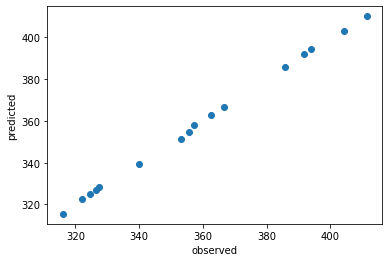

In [10]:
# visualize the prediction, evaluate the model performance
import matplotlib.pyplot as plt
plt.plot(y_test,y_test_pred,'o')
plt.xlabel('observed')
plt.ylabel('predicted')

In [11]:
# model evaluation
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y_test,y_test_pred)


0.6637767171306825

In [12]:
r2_score(y_test,y_test_pred)

0.9992780217164984

#### Take advantages of the model to predict future co2

In [13]:
import numpy as np
data_year =np.arange(1959,2201,1)
data_year = pd.DataFrame(data_year)
#data_year = data_year.rename(columns)
data_co2 = pipe.predict(data_year)
data_co2

data_year = data_year.to_numpy()


## Pco2 vs time

(array([ 200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

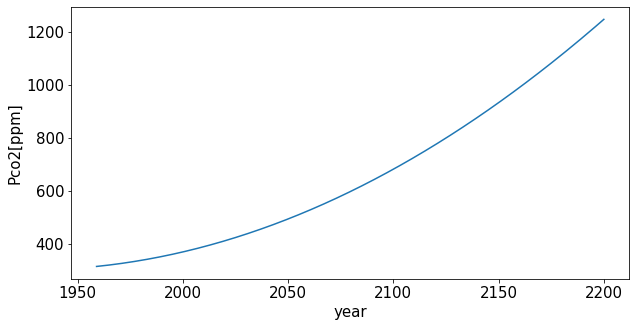

In [14]:
# plotting part
plt.figure(figsize=(10,5))
plt.plot(data_year,data_co2)
plt.xlabel('year',size=15)
plt.ylabel('Pco2[ppm]',size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## PH vs time

In [15]:
## given Pco2 and Ct, calculate PH
#Pco2 = data_co2*1e-6 #atm
#Ct = 2e-3 # 3mM

#KH = 10**(-1.5) # mol/L-atm
#Kw = 1e-14
#Ka1 = 10**(-6.3)
#Ka2 = 10**(-10.3)

#alpha0 = Pco2*KH/Ct

In [16]:
#def solve_equations(alpha0):
#    H_conc = sp.Symbol('H_conc')
#    eq = (H_conc**2)/(H_conc**2+Ka1*H_conc+Ka1*Ka2) - alpha0
#    H_conc_solution=list(sp.solveset(eq))
#   H_conc_final = H_conc_solution[-1]
#    PH = -np.log10(float(H_conc_final))
#    return(PH)


In [17]:
# given Pco2 and Alk, calculate PH
Pco2 = data_co2*1e-6 #atm
Alk = 2.2e-3 # 2mM
Alk = 2.25e-3 # 2mM

KH = 10**(-1.5) # mol/L-atm
Kw = 1e-14
Ka1 = 10**(-6.3)
Ka2 = 10**(-10.3)

In [18]:
def solve_equations(Pco2):
    H_conc = sp.Symbol('H_conc')
    eq = Ka1/H_conc*KH*Pco2- Alk
    H_conc_solution=list(sp.solveset(eq))
    # get the final result
    H_conc_final = (H_conc_solution[-1])
    PH = -np.log10(float(H_conc_final))
    return(PH)

In [19]:
# create dataframe to include all alpha0, PCO2, PH information
df=pd.DataFrame(data=data_co2,columns = ['Pco2'])
df['PH'] = (df['Pco2']*1e-6).apply(solve_equations)
df['year'] = data_year
df.head(61)

,Pco2,PH,year
0,315.476052,8.653216,1959
1,316.306092,8.652075,1960
2,317.161453,8.650902,1961
3,318.042135,8.649698,1962
4,318.948138,8.648462,1963
...,...,...,...
56,400.953089,8.549089,2015
57,403.201122,8.546661,2016
58,405.474477,8.544219,2017
59,407.773153,8.541764,2018


(array([8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

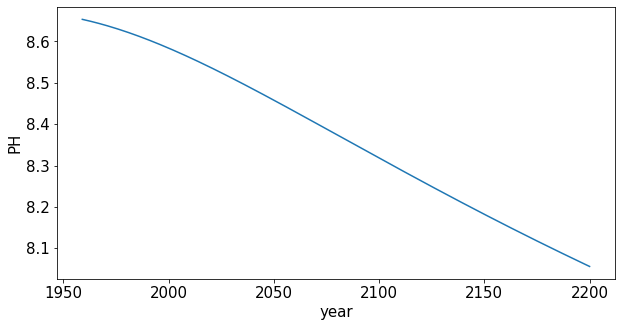

In [20]:
# plot PH vs year
plt.figure(figsize=(10,5))
plt.plot(df['year'],df['PH'])
plt.xlabel('year',size=15)
plt.ylabel('PH',size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## H2CO3 speciation

In [21]:
# get conc for H2CO3 system
H_conc = 10**(-df.PH)
OH = Kw/H_conc
alpha0 = (H_conc**2)/(H_conc**2+Ka1*H_conc+Ka1*Ka2)
alpha1 = (Ka1*H_conc)/(H_conc**2+Ka1*H_conc+Ka1*Ka2)
alpha2 = (Ka1*Ka2)/(H_conc**2+Ka1*H_conc+Ka1*Ka2)

Ct = Alk/(alpha1+2*alpha2)



In [22]:
H2X = Ct*alpha0
HX = Ct*alpha1
X = Ct*alpha2
df['H+'] = H_conc
df['OH-'] = OH
df['H2CO3'] = H2X
df['HCO3'] = HX
df['CO3'] = X

In [70]:
(df['H2CO3']/Ct)[60:]

60     0.005634
61     0.005666
62     0.005699
63     0.005732
64     0.005766
         ...   
237    0.016766
238    0.016859
239    0.016952
240    0.017045
241    0.017139
Length: 182, dtype: float64

In [72]:
df.year[60:]

60     2019
61     2020
62     2021
63     2022
64     2023
       ... 
237    2196
238    2197
239    2198
240    2199
241    2200
Name: year, Length: 182, dtype: int32

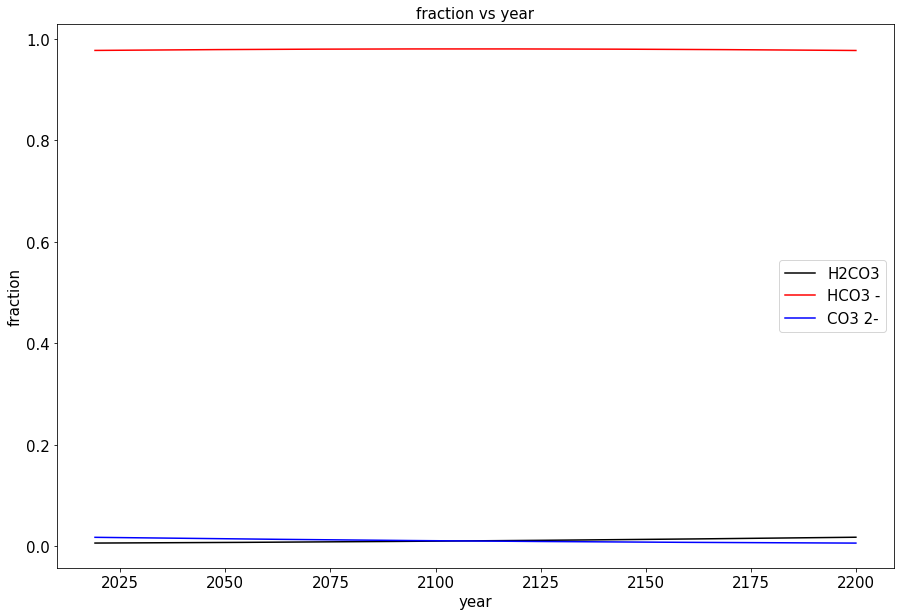

In [71]:
# plotting
plt.figure(figsize=(15,10))

# x vs y
plt.plot(df.year[60:], (df['H2CO3']/Ct)[60:], color='black', label = 'H2CO3')
plt.plot(df.year[60:], (df['HCO3']/Ct)[60:], color='red', label = 'HCO3 -')
plt.plot(df.year[60:], (df['CO3']/Ct)[60:], color='blue', label = 'CO3 2-')


# change for the axis direction
#ax = plt.gca()
#ax.xaxis.set_ticks_position('top')  
#ax.invert_yaxis()  

# legend, labels, fontsize, title
plt.legend(prop={'size':15})
plt.xlabel('year', fontsize=15)
plt.ylabel('fraction', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('fraction vs year',  fontsize=15)

# range of axis
#plt.ylim(14, 0)
#plt.xlim(0, 14)

# if we need to use log scale!!!!!!!
#plt.xscale('log')

plt.show() 

In [24]:
# change fraction
diff_frac_H2CO3 = (df.H2CO3.iloc[-1]-df.H2CO3.iloc[60])/df.H2CO3.iloc[60]
diff_frac_HCO3 = (df.HCO3.iloc[-1]-df.HCO3.iloc[60])/df.HCO3.iloc[60]
diff_frac_CO3 = (df.CO3.iloc[-1]-df.CO3.iloc[60])/df.CO3.iloc[60]
diff_frac_OH  = (df['OH-'].iloc[-1] - df['OH-'].iloc[60])/df['OH-'].iloc[60]
print('In the next 180 years, the fraction of H2CO3 would increace by a factor of', np.round(diff_frac_H2CO3+1))
print('In the next 180 years, the fraction of HCO3 - would increace by', np.round(diff_frac_HCO3*100,1), '%')
print('In the next 180 years, the fraction of CO3 2- would increace by', np.round(diff_frac_CO3*100,1), '%')
print('In the next 180 years, the fraction of OH- would increace by', np.round(diff_frac_OH*100,1), '%')



print('In the next 180 years, the PH would decrease from', round(df.PH.iloc[60],2), 'to',round(df.PH.iloc[-1],2))

In the next 180 years, the fraction of H2CO3 would increace by a factor of 3.0
In the next 180 years, the fraction of HCO3 - would increace by 2.3 %
In the next 180 years, the fraction of CO3 2- would increace by -66.4 %
In the next 180 years, the fraction of OH- would increace by -67.1 %
In the next 180 years, the PH would decrease from 8.54 to 8.06


In [25]:
diff_frac_OH

-0.6713459578848368

In [26]:
diff_frac_CO3

-0.6637761236827688

## Fe speciation(obsolete)

In [27]:
Po2 = 0.21 #atm
PE = 20.78 - df.PH + 0.25*np.log10(Po2)
df['PE'] = PE

(array([11.9, 12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

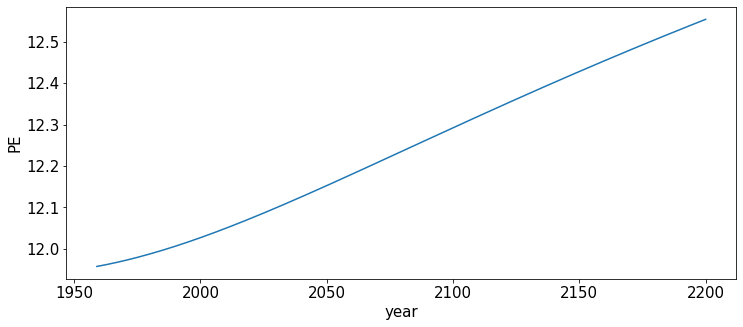

In [28]:
# plot PE vs year
plt.figure(figsize=(12,5))
plt.plot(df['year'],df['PE'])
plt.xlabel('year',size=15)
plt.ylabel('PE',size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [29]:
# constant value
e = 10**(-PE)
K = 1e13
# calculate fraction
fraction_Fe_two = K*e/(1+K*e)
fraction_Fe_three = 1-fraction_Fe_two

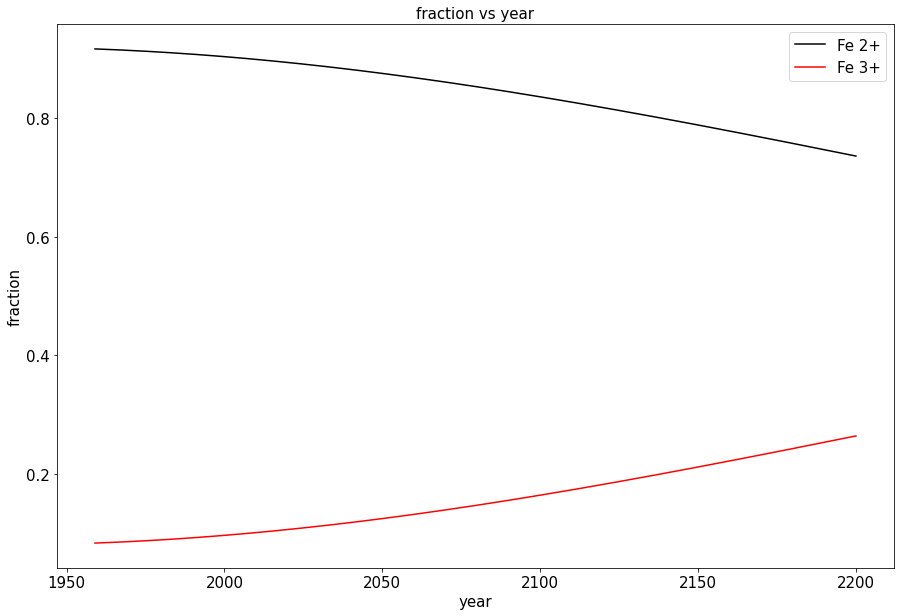

In [30]:
# plotting for Fe speciation
plt.figure(figsize=(15,10))

# x vs y
plt.plot(df.year, fraction_Fe_two, color='black', label = 'Fe 2+')
plt.plot(df.year, fraction_Fe_three, color='red', label = 'Fe 3+')

# change for the axis direction
#ax = plt.gca()
#ax.xaxis.set_ticks_position('top')  
#ax.invert_yaxis()  

# legend, labels, fontsize, title
plt.legend(prop={'size':15})
plt.xlabel('year', fontsize=15)
plt.ylabel('fraction', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('fraction vs year',  fontsize=15)

# range of axis
#plt.ylim(14, 0)
#plt.xlim(0, 14)

# if we need to use log scale!!!!!!!
#plt.xscale('log')

plt.show() 

In [31]:
diff_frac_Fe_two = (fraction_Fe_two.iloc[-1]-fraction_Fe_two.iloc[60])/fraction_Fe_two.iloc[60]
diff_frac_Fe_thee = (fraction_Fe_three.iloc[-1]-fraction_Fe_three.iloc[60])/fraction_Fe_three.iloc[60]

print('In the next 180 years, the fraction of Fe 2+ would increace by', round(diff_frac_Fe_two*100,2), '%')
print('In the next 180 years, the fraction of Fe 3+ would increace by', round(diff_frac_Fe_thee*100,2), '%')

In the next 180 years, the fraction of Fe 2+ would increace by -17.72 %
In the next 180 years, the fraction of Fe 3+ would increace by 150.36 %


## Fe(III) complexation speciation, assuming not much Fe(II)

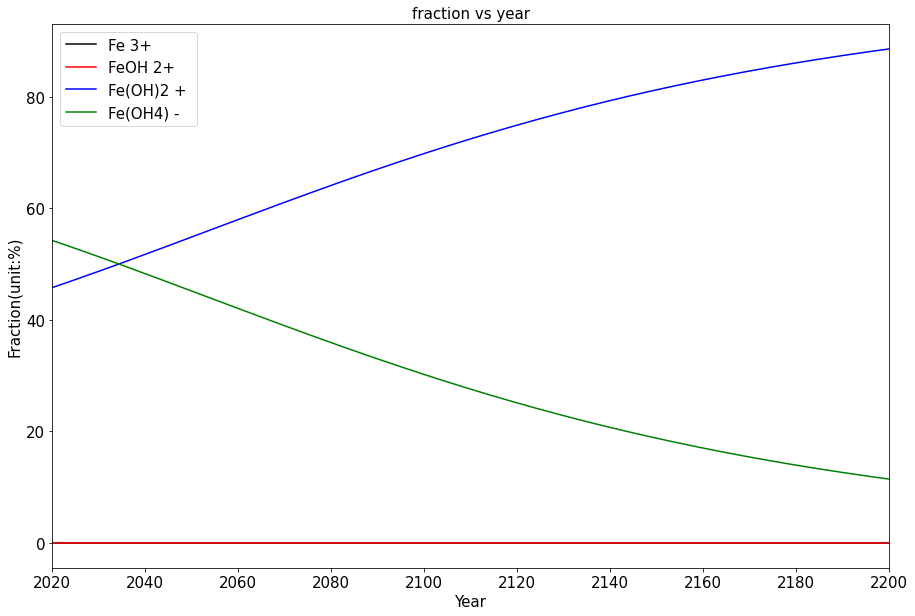

In [80]:
K1 = 10**(11.81)
K2 = 10**(23.4) 
K3 = 10**(34.4)

f_Fe = 1/(1 + K1*OH + K2*(OH**2) + K3*(OH**4))*100
f_FeOH = (K1*OH)/(1 + K1*OH + K2*(OH**2) + K3*(OH**4))*100
f_FeOH2 = K2*(OH**2)/(1 + K1*OH + K2*(OH**2) + K3*(OH**4))*100
f_FeOH4 = K3*(OH**4)/(1 + K1*OH + K2*(OH**2) + K3*(OH**4))*100

# plotting
plt.figure(figsize=(15,10))

# x vs y
plt.plot(df.year[60:], f_Fe[60:], color='black', label = 'Fe 3+')
plt.plot(df.year[60:], f_FeOH[60:], color='red', label = 'FeOH 2+ ')
plt.plot(df.year[60:], f_FeOH2[60:], color='blue', label = 'Fe(OH)2 + ')
plt.plot(df.year[60:], f_FeOH4[60:], color='green', label = 'Fe(OH4) -')


# change for the axis direction
#ax = plt.gca()
#ax.xaxis.set_ticks_position('top')  
#ax.invert_yaxis()  

# legend, labels, fontsize, title
plt.legend(prop={'size':15})
plt.xlabel('Year', fontsize=15)
plt.ylabel('Fraction(unit:%)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('fraction vs year',  fontsize=15)
plt.xlim(2020,2200)

# range of axis
#plt.ylim(14, 0)
#plt.xlim(0, 14)

# if we need to use log scale!!!!!!!
#plt.xscale('log')

plt.show() 

In [33]:
df['fraction of Fe3+'] = f_Fe
df['fraction of FeOH 2+'] = f_FeOH
df['fraction of FeOH2 +'] = f_FeOH2
df['fraction of FeOH4 -'] = f_FeOH4

In [82]:
# change fraction
diff_frac_Fe = (df['fraction of Fe3+'] .iloc[-1]-df['fraction of Fe3+'].iloc[60])/df['fraction of Fe3+'].iloc[60]
diff_frac_FeOH = (df['fraction of FeOH 2+'] .iloc[-1]-df['fraction of FeOH 2+'].iloc[60])/df['fraction of FeOH 2+'].iloc[60]
diff_frac_FeOH2 =  (df['fraction of FeOH2 +'] .iloc[-1]-df['fraction of FeOH2 +'].iloc[60])/df['fraction of FeOH2 +'].iloc[60]
diff_frac_FeOH4 =  (df['fraction of FeOH4 -'] .iloc[-1]-df['fraction of FeOH4 -'].iloc[60])/df['fraction of FeOH4 -'].iloc[60]



print('In the next 180 years, the fraction of Fe would increace by a factor of', np.round(diff_frac_Fe+1,2))
print('In the next 180 years, the fraction of FeOH 2+ would increace by', np.round(diff_frac_FeOH*100,2), '%')
print('In the next 180 years, the fraction of FeOH2 + would increace by', np.round(diff_frac_FeOH2*100,2), '%')
print('In the next 180 years, the fraction of FeOH4 - would increace by', np.round(diff_frac_FeOH4*100,2), '%')

print('In the next 180 years, the PH would decrease from', round(df.PH.iloc[60],2), 'to',round(df.PH.iloc[-1],2))

In the next 180 years, the fraction of Fe would increace by a factor of 18.02
In the next 180 years, the fraction of FeOH 2+ would increace by 492.24 %
In the next 180 years, the fraction of FeOH2 + would increace by 94.64 %
In the next 180 years, the fraction of FeOH4 - would increace by -78.98 %
In the next 180 years, the PH would decrease from 8.54 to 8.06


## Fe(II) complexation speciation (obsolete)

In [35]:
#K1 = 10**(4.6)
#K2 = 10**(7.5) 
#K3 = 10**(13)
#K4 = 10**(10)
#K5 = 10**(1.1)

#f_Fe = 1/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['HCO3']))
#f_FeOH = (K1*OH)/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['HCO3']))
#f_FeOH2 = K2*(OH**2)/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['HCO3']))
#f_FeOH3 = K3*(OH**3)/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['HCO3']))
#f_FeOH4 = K4*(OH**4)/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['HCO3']))
#f_FeHCO3 = K5*(df['HCO3'])/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['HCO3']))



In [36]:
# plotting
#plt.figure(figsize=(15,10))#

# x vs y
#plt.plot(df.year, f_Fe, color='black', label = 'Fe 2+')
#plt.plot(df.year, f_FeOH, color='red', label = 'FeOH + ')
#plt.plot(df.year, f_FeOH2, color='blue', label = 'Fe(OH)2 ')
#plt.plot(df.year, f_FeOH3, color='yellow', label = 'Fe(OH3) +')
#plt.plot(df.year, f_FeOH4, color='green', label = 'Fe(OH4) 2+')
#plt.plot(df.year, f_FeHCO3, color='purple', label = 'FeHCO3 +')


# change for the axis direction
#ax = plt.gca()
#ax.xaxis.set_ticks_position('top')  
#ax.invert_yaxis()  

# legend, labels, fontsize, title
#plt.legend(prop={'size':15})
#plt.xlabel('year', fontsize=15)
#plt.ylabel('fraction', fontsize=15)
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.title('fraction vs year',  fontsize=15)

# range of axis
#plt.ylim(14, 0)
#plt.xlim(0, 14)

# if we need to use log scale!!!!!!!
#plt.xscale('log')

#plt.show() 

## Cu(II) complexation speciation

In [37]:
# with OH
K1 = 10**(6.5)
K2 = 10**(11.8) 
K3 = 10**(14.5)
K4 = 10**(15.6)

# with CO3
K5 = 10**(6.77)
K6 = 10**(1.8)
K7 = 10**(10.2)


# OH
f_Cu = 1/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['CO3']) + K6*(df['HCO3']) + K7*((df['CO3'])**2))*100
f_CuOH = (K1*OH)/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['CO3']) + K6*(df['HCO3']) + K7*((df['CO3'])**2))*100
f_CuOH2 = K2*(OH**2)/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['CO3']) + K6*(df['HCO3']) + K7*((df['CO3'])**2))*100
f_CuOH3 = K3*(OH**3)/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['CO3']) + K6*(df['HCO3']) + K7*((df['CO3'])**2))*100
f_CuOH4 = K4*(OH**4)/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['CO3']) + K6*(df['HCO3']) + K7*((df['CO3'])**2))*100

# CO3
f_CuCO3 =  K5*(df['CO3'])/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['CO3']) + K6*(df['HCO3']) + K7*((df['CO3'])**2))*100
f_CuHCO3 =  K6*(df['HCO3'])/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['CO3']) + K6*(df['HCO3']) + K7*((df['CO3'])**2))*100
f_CuCO3_2 = K7*((df['CO3'])**2)/(1 + K1*OH + K2*(OH**2) + K3*(OH**3) + K4*(OH**4) + K5*(df['CO3']) + K6*(df['HCO3']) + K7*((df['CO3'])**2))*100



In [38]:
print(f_Cu)

0      0.284533
1      0.285353
2      0.286198
3      0.287068
4      0.287963
         ...   
237    1.180691
238    1.187412
239    1.194157
240    1.200926
241    1.207718
Length: 242, dtype: float64


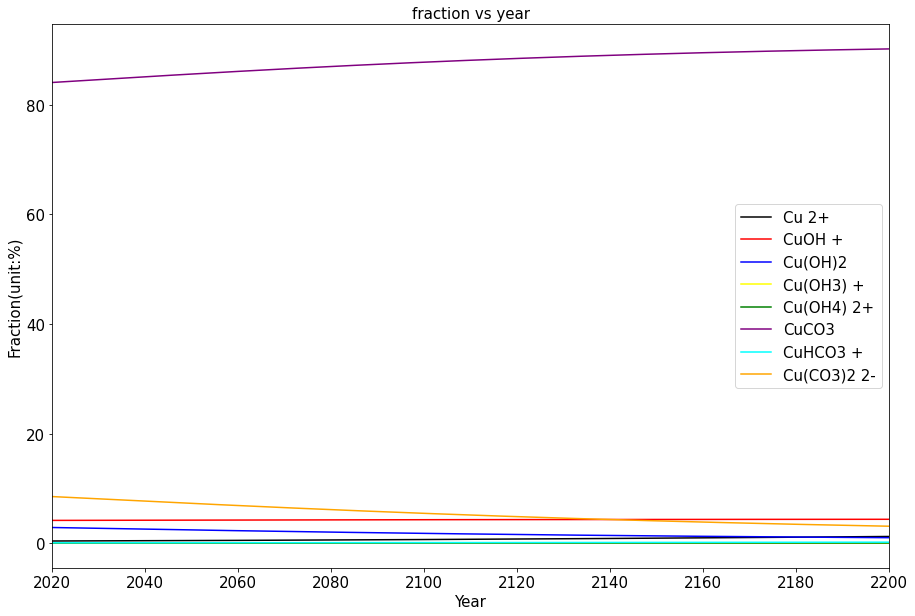

In [79]:
# plotting
plt.figure(figsize=(15,10))

# x vs y
plt.plot(df.year[60:], f_Cu[60:], color='black', label = 'Cu 2+')
plt.plot(df.year[60:], f_CuOH[60:], color='red', label = 'CuOH + ')
plt.plot(df.year[60:], f_CuOH2[60:], color='blue', label = 'Cu(OH)2 ')
plt.plot(df.year[60:], f_CuOH3[60:], color='yellow', label = 'Cu(OH3) +')
plt.plot(df.year[60:], f_CuOH4[60:], color='green', label = 'Cu(OH4) 2+')

plt.plot(df.year[60:], f_CuCO3[60:], color='purple', label = 'CuCO3')
plt.plot(df.year[60:], f_CuHCO3[60:], color='cyan', label = 'CuHCO3 +')
plt.plot(df.year[60:], f_CuCO3_2[60:], color='orange', label = 'Cu(CO3)2 2-')



# change for the axis direction
#ax = plt.gca()
#ax.xaxis.set_ticks_position('top')  
#ax.invert_yaxis()  

# legend, labels, fontsize, title
plt.legend(prop={'size':15})
plt.xlabel('Year', fontsize=15)
plt.ylabel('Fraction(unit:%)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('fraction vs year',  fontsize=15)

#dim=np.arange(2019,2200,5)
plt.xlim(2020,2200)


# range of axis
#plt.ylim(14, 0)
#plt.xlim(0, 14)

# if we need to use log scale!!!!!!!
#plt.xscale('log')

plt.show() 

In [40]:
df['fraction of Cu 2+'] = f_Cu
df['fraction of CuOH +'] = f_CuOH
df['fraction of CuOH2'] = f_CuOH2
df['fraction of CuOH3 -'] = f_CuOH3
df['fraction of CuOH4 2-'] = f_CuOH4
df['fraction of CuCO3'] = f_CuCO3
df['fraction of CuHCO3 +'] = f_CuHCO3
df['fraction of Cu(CO3)2 2-'] = f_CuCO3_2


In [42]:
# change fraction
diff_frac_Cu = (df['fraction of Cu 2+'] .iloc[-1]-df['fraction of Cu 2+'].iloc[60])/df['fraction of Cu 2+'].iloc[60]
diff_frac_CuOH = (df['fraction of CuOH +'] .iloc[-1]-df['fraction of CuOH +'].iloc[60])/df['fraction of CuOH +'].iloc[60]
diff_frac_CuOH2 =  (df['fraction of CuOH2'] .iloc[-1]-df['fraction of CuOH2'].iloc[60])/df['fraction of CuOH2'].iloc[60]
diff_frac_CuOH3 =  (df['fraction of CuOH3 -'] .iloc[-1]-df['fraction of CuOH3 -'].iloc[60])/df['fraction of CuOH3 -'].iloc[60]
diff_frac_CuOH4 =  (df['fraction of CuOH4 2-'] .iloc[-1]-df['fraction of CuOH4 2-'].iloc[60])/df['fraction of CuOH4 2-'].iloc[60]
diff_frac_CuCO3 =  (df['fraction of CuCO3'] .iloc[-1]-df['fraction of CuCO3'].iloc[60])/df['fraction of CuCO3'].iloc[60]
diff_frac_CuHCO3 =  (df['fraction of CuHCO3 +'] .iloc[-1]-df['fraction of CuHCO3 +'].iloc[60])/df['fraction of CuHCO3 +'].iloc[60]
diff_frac_CuCO3_2=  (df['fraction of Cu(CO3)2 2-'] .iloc[-1]-df['fraction of Cu(CO3)2 2-'].iloc[60])/df['fraction of Cu(CO3)2 2-'].iloc[60]



print('In the next 180 years, the fraction of Cu2+ would increace by a factor of', np.round(diff_frac_Cu+1,2))
print('In the next 180 years, the fraction of CuOH+ would increace by', np.round(diff_frac_CuOH*100,2), '%')
print('In the next 180 years, the fraction of CuOH2 would increace by', np.round(diff_frac_CuOH2*100,2), '%')
print('In the next 180 years, the fraction of CuOH3- would increace by', np.round(diff_frac_CuOH3*100,2), '%')
print('In the next 180 years, the fraction of CuOH4 2- would increace by', np.round(diff_frac_CuOH4*100,2), '%')
print('In the next 180 years, the fraction of CuCO3 would increace by', np.round(diff_frac_CuCO3*100,2), '%')
print('In the next 180 years, the fraction of CuHCO3 would increace by', np.round(diff_frac_CuHCO3*100,2), '%')
print('In the next 180 years, the fraction of Cu(CO3)2 would increace by', np.round(diff_frac_CuCO3_2*100,2), '%')



In the next 180 years, the fraction of Cu2+ would increace by a factor of 3.19
In the next 180 years, the fraction of CuOH+ would increace by 4.94 %
In the next 180 years, the fraction of CuOH2 would increace by -65.51 %
In the next 180 years, the fraction of CuOH3- would increace by -88.67 %
In the next 180 years, the fraction of CuOH4 2- would increace by -96.27 %
In the next 180 years, the fraction of CuCO3 would increace by 7.35 %
In the next 180 years, the fraction of CuHCO3 would increace by 226.65 %
In the next 180 years, the fraction of Cu(CO3)2 would increace by -63.91 %


## save out dataframe

In [43]:
result = df 
result.to_csv("output.csv")

In [44]:
df.iloc[60]

Pco2                       4.100971e+02
PH                         8.539296e+00
year                       2.019000e+03
H+                         2.888712e-09
OH-                        3.461751e-06
H2CO3                      1.253350e-05
HCO3                       2.174544e-03
CO3                        3.772802e-05
PE                         1.207126e+01
fraction of Fe3+           1.511149e-11
fraction of FeOH 2+        3.377559e-05
fraction of FeOH2 +        4.548820e+01
fraction of FeOH4 -        5.451177e+01
fraction of Cu 2+          3.782477e-01
fraction of CuOH +         4.140684e+00
fraction of CuOH2          2.860012e+00
fraction of CuOH3 -        4.962079e-03
fraction of CuOH4 2-       2.162516e-07
fraction of CuCO3          8.403115e+01
fraction of CuHCO3 +       5.189727e-02
fraction of Cu(CO3)2 2-    8.533049e+00
Name: 60, dtype: float64

In [45]:
df.iloc[-1]

Pco2                       1.247808e+03
PH                         8.056035e+00
year                       2.200000e+03
H+                         8.789522e-09
OH-                        1.137718e-06
H2CO3                      3.901423e-05
HCO3                       2.224630e-03
CO3                        1.268506e-05
PE                         1.255452e+01
fraction of Fe3+           2.723117e-10
fraction of FeOH 2+        2.000328e-04
fraction of FeOH2 +        8.853925e+01
fraction of FeOH4 -        1.146055e+01
fraction of Cu 2+          1.207718e+00
fraction of CuOH +         4.345107e+00
fraction of CuOH2          9.863594e-01
fraction of CuOH3 -        5.624319e-04
fraction of CuOH4 2-       8.055726e-09
fraction of CuCO3          9.021073e+01
fraction of CuHCO3 +       1.695210e-01
fraction of Cu(CO3)2 2-    3.080000e+00
Name: 241, dtype: float64

In [51]:
data_new = pd.DataFrame(df.iloc[60])
data_new['2200'] = df.iloc[-1]


In [52]:
data_new.columns=['2019','2200']
data_new = data_new.drop(['year'])

In [53]:
data_new

,2019,2200
Pco2,4.100971e+02,1.247808e+03
PH,8.539296e+00,8.056035e+00
H+,2.888712e-09,8.789522e-09
OH-,3.461751e-06,1.137718e-06
H2CO3,1.253350e-05,3.901423e-05
HCO3,2.174544e-03,2.224630e-03
CO3,3.772802e-05,1.268506e-05
PE,1.207126e+01,1.255452e+01
fraction of Fe3+,1.511149e-11,2.723117e-10
fraction of FeOH 2+,3.377559e-05,2.000328e-04


In [54]:
data_new_transpose = pd.DataFrame.transpose(data_new)
data_new_transpose

,Pco2,PH,H+,OH-,H2CO3,HCO3,CO3,PE,fraction of Fe3+,fraction of FeOH 2+,fraction of FeOH2 +,fraction of FeOH4 -,fraction of Cu 2+,fraction of CuOH +,fraction of CuOH2,fraction of CuOH3 -,fraction of CuOH4 2-,fraction of CuCO3,fraction of CuHCO3 +,fraction of Cu(CO3)2 2-
2019,410.097150,8.539296,2.888712e-09,0.000003,0.000013,0.002175,0.000038,12.071259,1.511149e-11,0.000034,45.488198,54.511768,0.378248,4.140684,2.860012,0.004962,2.162516e-07,84.031147,0.051897,8.533049
2200,1247.808021,8.056035,8.789522e-09,0.000001,0.000039,0.002225,0.000013,12.554520,2.723117e-10,0.000200,88.539253,11.460547,1.207718,4.345107,0.986359,0.000562,8.055726e-09,90.210732,0.169521,3.080000


In [59]:
data_new.to_csv("prediction.csv")